In [ ]:
!pip install tensorflow tensorflowjs pandas matplotlib scikit-learn opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from google.colab import drive
import cv2

In [ ]:
drive.mount('/content/drive')

# Unzip image files
!unzip -q '/content/drive/MyDrive/HAM10000/HAM10000_images_part_1.zip' -d ./HAM10000_images
!unzip -q '/content/drive/MyDrive/HAM10000/HAM10000_images_part_2.zip' -d ./HAM10000_images

# Unzip test image files to the correct location
!unzip -q '/content/drive/MyDrive/HAM10000/ISIC2018_Task3_Test_Images.zip' -d /content/ISIC2018_Test_Images

# Load metadata
metadata = pd.read_csv('/content/drive/MyDrive/HAM10000/HAM10000_metadata.csv')
test_metadata = pd.read_csv('/content/drive/MyDrive/HAM10000/ISIC2018_Task3_Test_GroundTruth.csv')

print("Test metadata shape:", test_metadata.shape)
print("Test metadata columns:", test_metadata.columns)

# Assign image paths for HAM10000
image_dir = './HAM10000_images'
metadata['image_path'] = metadata['image_id'].apply(lambda x: os.path.join(image_dir, f'{x}.jpg'))

# Assign image paths for test data - ensure this points to the correct unzipped location
test_image_dir = '/content/ISIC2018_Test_Images/ISIC2018_Task3_Test_Images' # Corrected path based on typical unzip structure
test_metadata['image_path'] = test_metadata['image_id'].apply(lambda x: os.path.join(test_image_dir, f'{x}.jpg'))


# Filter only existing images
import os
metadata = metadata[metadata['image_path'].apply(os.path.exists)]
test_metadata = test_metadata[test_metadata['image_path'].apply(os.path.exists)]

# Confirm
print("After filtering, metadata shape:", metadata.shape)
print("After filtering, test_metadata shape:", test_metadata.shape)

# Only print sample path if test_metadata is not empty
if not test_metadata.empty:
    print("Sample test image path:", test_metadata['image_path'].iloc[0])
    print("Exists?", os.path.exists(test_metadata['image_path'].iloc[0]))
else:
    print("Test metadata is empty after filtering. Check unzipping path and file existence.")

Mounted at /content/drive
Test metadata shape: (1512, 8)
Test metadata columns: Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'dataset'],
      dtype='object')
After filtering, metadata shape: (10015, 8)
After filtering, test_metadata shape: (1511, 9)
Sample test image path: /content/ISIC2018_Test_Images/ISIC2018_Task3_Test_Images/ISIC_0034524.jpg
Exists? True


In [ ]:
# !unzip -q "/content/drive/MyDrive/HAM10000/ISIC2018_Task3_Test_Images.zip" -d /content/ISIC2018_Test_Images


replace /content/ISIC2018_Test_Images/ISIC2018_Task3_Test_Images/ISIC_0035920.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!find /content/drive/MyDrive -name "ISIC_*.jpg"


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set constants
IMAGE_SIZE = 128
BATCH_SIZE = 64

# Clean labels
metadata = metadata[metadata['dx'].notnull()]
metadata['dx'] = metadata['dx'].astype(str)

# Assign image paths for HAM10000 (train + validation)
image_dir = './HAM10000_images'
metadata['image_path'] = metadata['image_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
metadata = metadata[metadata['image_path'].apply(os.path.exists)]

print("Metadata columns:", metadata.columns)
print("Metadata shape after filtering:", metadata.shape)

# ✅ Correct test image folder path
test_image_dir = '/content/ISIC2018_Test_Images/ISIC2018_Task3_Test_Images'

# Assign image paths for test set
test_metadata['image_path'] = test_metadata['image_id'].apply(
    lambda x: os.path.join(test_image_dir, f"{x}.jpg")
)
test_metadata = test_metadata[test_metadata['image_path'].apply(os.path.exists)]

# Final test metadata check
print("Test metadata shape after filtering:", test_metadata.shape)
print("Test metadata columns:", test_metadata.columns)
print("Sample test image path:", test_metadata['image_path'].iloc[0])
print("Exists?", os.path.exists(test_metadata['image_path'].iloc[0]))

# ✅ Split training and validation sets
train_df, val_df = train_test_split(
    metadata,
    test_size=0.2,
    stratify=metadata['dx'],
    random_state=42
)

# ✅ Set up data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=20
)

# ✅ Generators
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='dx',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='dx',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ✅ Test generator (rescale only)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_metadata,
    x_col='image_path',
    y_col='dx',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Metadata columns: Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'image_path'],
      dtype='object')
Metadata shape after filtering: (10015, 8)
Test metadata shape after filtering: (1511, 9)
Test metadata columns: Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'dataset', 'image_path'],
      dtype='object')
Sample test image path: /content/ISIC2018_Test_Images/ISIC2018_Task3_Test_Images/ISIC_0034524.jpg
Exists? True
Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Found 1511 validated image filenames belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[-20:]:
    layer.trainable = True
  # Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Slower learning to prevent overfitting
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=14
)

model.save('skin_cancer_model.h5')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/14
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4778 - loss: 1.5973

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


126/126 ━━━━━━━━━━━━━━━━━━━━ 1023s 8s/step - accuracy: 0.4784 - loss: 1.5963 - val_accuracy: 0.0624 - val_loss: 1.9224
Epoch 2/14
126/126 ━━━━━━━━━━━━━━━━━━━━ 945s 7s/step - accuracy: 0.6353 - loss: 1.1944 - val_accuracy: 0.6685 - val_loss: 6.1393
Epoch 3/14
126/126 ━━━━━━━━━━━━━━━━━━━━ 931s 7s/step - accuracy: 0.6738 - loss: 1.0183 - val_accuracy: 0.6510 - val_loss: 3.4023
Epoch 4/14
126/126 ━━━━━━━━━━━━━━━━━━━━ 959s 8s/step - accuracy: 0.6817 - loss: 0.9525 - val_accuracy: 0.5092 - val_loss: 1.8321
Epoch 5/14
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6944 - loss: 0.8811

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


126/126 ━━━━━━━━━━━━━━━━━━━━ 943s 7s/step - accuracy: 0.6944 - loss: 0.8811 - val_accuracy: 0.6435 - val_loss: 1.3215
Epoch 6/14
126/126 ━━━━━━━━━━━━━━━━━━━━ 938s 7s/step - accuracy: 0.7003 - loss: 0.8707 - val_accuracy: 0.6540 - val_loss: 1.0728
Epoch 7/14
 77/126 ━━━━━━━━━━━━━━━━━━━━ 5:40 7s/step - accuracy: 0.7044 - loss: 0.8421

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7072 - loss: 0.8348

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


126/126 ━━━━━━━━━━━━━━━━━━━━ 941s 7s/step - accuracy: 0.7072 - loss: 0.8346 - val_accuracy: 0.6710 - val_loss: 1.1455
Epoch 8/14
120/126 ━━━━━━━━━━━━━━━━━━━━ 42s 7s/step - accuracy: 0.7060 - loss: 0.8336

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


126/126 ━━━━━━━━━━━━━━━━━━━━ 949s 8s/step - accuracy: 0.7068 - loss: 0.8315 - val_accuracy: 0.6141 - val_loss: 1.2506
Epoch 9/14
126/126 ━━━━━━━━━━━━━━━━━━━━ 947s 8s/step - accuracy: 0.7335 - loss: 0.7666 - val_accuracy: 0.4863 - val_loss: 1.4405
Epoch 10/14
126/126 ━━━━━━━━━━━━━━━━━━━━ 950s 8s/step - accuracy: 0.7412 - loss: 0.7419 - val_accuracy: 0.4124 - val_loss: 1.5135
Epoch 11/14
126/126 ━━━━━━━━━━━━━━━━━━━━ 967s 8s/step - accuracy: 0.7462 - loss: 0.7263 - val_accuracy: 0.4039 - val_loss: 1.6148
Epoch 12/14
 98/126 ━━━━━━━━━━━━━━━━━━━━ 3:16 7s/step - accuracy: 0.7513 - loss: 0.6958

In [ ]:
import json

class_indices = train_generator.class_indices
with open('class_indices.json', 'w') as json_file:
    json.dump(class_indices, json_file)

#Prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted cancer type: nv
Confidence: 0.8401566743850708
Description: Melanocytic nevi


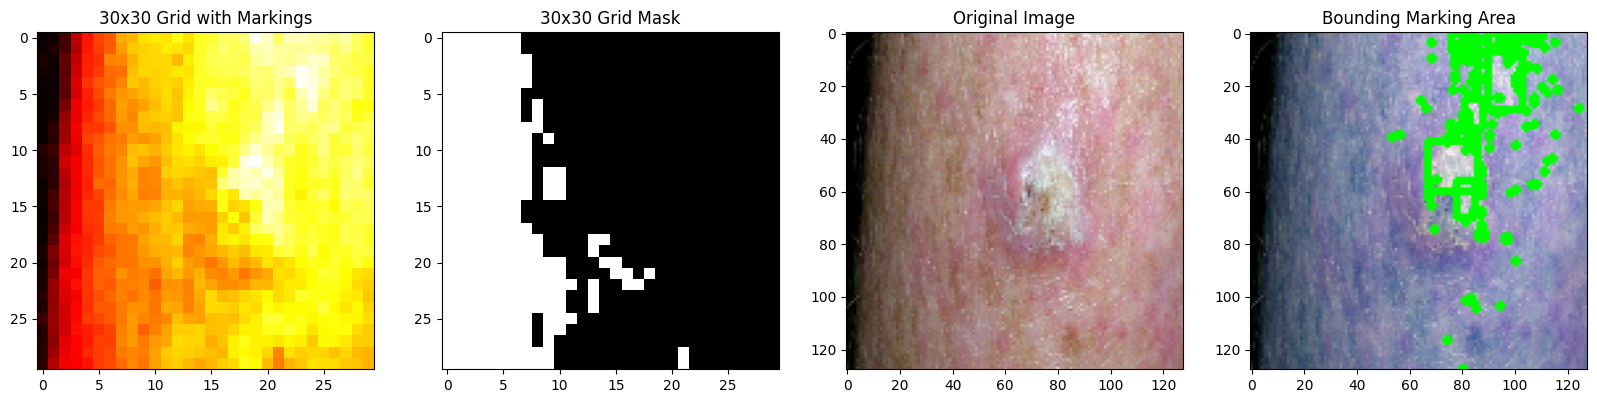

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import load_model

IMAGE_SIZE = 128

model = load_model('skin_cancer_model.h5')

with open('class_indices.json', 'r') as json_file:
    class_indices = json.load(json_file)

cancer_descriptions = {
    'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowen\'s disease',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions (angiomas, angiokeratomas, pyogenic granulomas, and hemorrhage)',
    'healthy': 'This is healthy skin'
}

def generate_grid_image(image_array, grid_size=30):
    grid = np.zeros((grid_size, grid_size))
    image_shape = image_array.shape[:2]
    step_x = image_shape[0] // grid_size
    step_y = image_shape[1] // grid_size

    for i in range(grid_size):
        for j in range(grid_size):
            grid[i, j] = np.mean(image_array[i*step_x:(i+1)*step_x, j*step_y:(j+1)*step_y])

    return grid

def generate_numerical_grid_image(image_array, threshold=0.5, grid_size=30):
    grid = np.zeros((grid_size, grid_size))
    image_shape = image_array.shape[:2]
    step_x = image_shape[0] // grid_size
    step_y = image_shape[1] // grid_size

    for i in range(grid_size):
        for j in range(grid_size):
            mean_value = np.mean(image_array[i*step_x:(i+1)*step_x, j*step_y:(j+1)*step_y])
            grid[i, j] = 1 if mean_value >= threshold else 0

    return grid

def generate_bounding_box(image_array, threshold=0.5):
    img = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        confidence = 1 if np.mean(image_array[y:y+h, x:x+w]) >= threshold else 0
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255 * confidence, 0), 2)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def generate_confidence_grid(predictions, grid_size):
    confidence_grid = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            confidence_grid[i, j] = predictions[0, i * grid_size + j] if i * grid_size + j < predictions.shape[1] else 0
    return confidence_grid

def predict_cancer(image_path):
    img = keras_image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = keras_image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions, axis=1)[0]
    predicted_label = list(class_indices.keys())[predicted_index]
    confidence = predictions[0][predicted_index]

    if predicted_label == 'healthy':
        return predicted_label, confidence, None, None, None, None, img_array

    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))

    grid_image = generate_grid_image(img_array[0])
    numerical_grid_image = generate_numerical_grid_image(img_array[0])
    bounding_box_image = generate_bounding_box(img)
    confidence_grid = generate_confidence_grid(predictions, grid_size=numerical_grid_image.shape[0])

    return predicted_label, confidence, grid_image, numerical_grid_image, bounding_box_image, confidence_grid, img

image_path = '/content/drive/MyDrive/HAM10000/img6.jpg'
predicted_label, confidence, grid_image, numerical_grid_image, bounding_box_image, confidence_grid, original_image_array = predict_cancer(image_path)

print(f"Predicted cancer type: {predicted_label}")
print(f"Confidence: {confidence}")
if original_image_array is not None:
    print(f"Description: {cancer_descriptions[predicted_label]}")

    fig, axs = plt.subplots(1, 4, figsize=(20, 20))
    axs[0].imshow(grid_image, cmap='hot', interpolation='nearest')
    axs[0].set_title('30x30 Grid with Markings')
    axs[1].imshow(numerical_grid_image, cmap='binary', interpolation='nearest')
    axs[1].set_title('30x30 Grid Mask')
    axs[2].imshow(cv2.cvtColor(original_image_array, cv2.COLOR_BGR2RGB))
    axs[2].set_title('Original Image')
    axs[3].imshow(bounding_box_image)
    axs[3].set_title('Bounding Marking Area')

    plt.show()
